## Check GPU states

In [0]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7413 sha256=28c833234f34a992452bf59d492ec132fc1840b83e834394b204d477dace52f8
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.8 GB  | Proc size: 157.5 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


In [0]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim #for gradient descent

torch.manual_seed(1) # set the random seed

In [0]:
# obtain data
from torchvision import datasets, transforms

## Download datasets

In [0]:
# set global path
PATH_TRAIN = "/content/train_set"
PATH_VALID = "/content/valid_set"

In [0]:
!cd /content/
!rm -r /content/* # clean up disks
!mkdir train_set_tensor
!mkdir valid_set_tensor

In [0]:
!wget http://yucanwu.com/aps360/set_a_5600.zip
!mkdir train_set
!unzip set_a_5600.zip -d ./train_set

!wget http://yucanwu.com/aps360/set_v_3500.zip
!unzip -q set_v_3500
!mv dataset_valid valid_set

!ls


流式输出内容被截断，只能显示最后 5000 行内容。
  inflating: ./train_set/0/406.jpg   
  inflating: ./train_set/0/409.jpg   
  inflating: ./train_set/0/41.jpg    
  inflating: ./train_set/0/42.jpg    
  inflating: ./train_set/0/425.jpg   
  inflating: ./train_set/0/433.jpg   
  inflating: ./train_set/0/434.jpg   
  inflating: ./train_set/0/452.jpg   
  inflating: ./train_set/0/454.jpg   
  inflating: ./train_set/0/461.jpg   
  inflating: ./train_set/0/469.jpg   
  inflating: ./train_set/0/470.jpg   
  inflating: ./train_set/0/476.jpg   
  inflating: ./train_set/0/48.jpg    
  inflating: ./train_set/0/482.jpg   
  inflating: ./train_set/0/489.jpg   
  inflating: ./train_set/0/49.jpg    
  inflating: ./train_set/0/491.jpg   
  inflating: ./train_set/0/496.jpg   
  inflating: ./train_set/0/499.jpg   
  inflating: ./train_set/0/503.jpg   
  inflating: ./train_set/0/508.jpg   
  inflating: ./train_set/0/514.jpg   
  inflating: ./train_set/0/516.jpg   
  inflating: ./train_set/0/52.jpg    
  inflating: ./train_se

In [0]:
# obtain data
from torchvision import datasets, transforms
import warnings

# PATH_OF_DATA = "/content/dataset/"
#PATH_OF_DATA = "/content/drive/My Drive/APS360/Emotion_Detection_CNN"
#PATH_OF_DATA = "/Users/kexinli/PycharmProjects/RECTnet"


def get_one_data_loader(path=PATH_TRAIN, batch_size=1, num_workers=1):
    """ NEW d
    """
    data_transform = transforms.Compose([transforms.Resize(224, 224),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    dataset = datasets.ImageFolder(path, transform=data_transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
    return loader

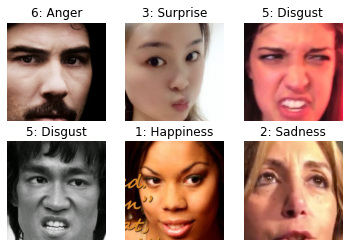

In [0]:
# test if works
train_loader = get_one_data_loader()
classes = ['0: Neutral', '1: Happiness', 
           '2: Sadness', '3: Surprise', 
           '4: Fear', '5: Disgust', '6: Anger']

k = 0
for images, labels in train_loader:
    # since batch_size = 1, there is only 1 image in `images`
    image = images[0]
    # place the colour channel at the end, instead of at the beginning
    img = np.transpose(image, [1,2,0])
    # normalize pixel intensity values to [0, 1]
    img = img / 2 + 0.5
    plt.subplot(2, 3, k+1)
    plt.axis('off')
    plt.imshow(img)
    plt.title(classes[labels[0]])

    k += 1
    if k >= 6:
        break

##Helper functions

In [0]:
###############################################################################
# Training
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

###############################################################################
# Training Curve
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_err = np.loadtxt("{}_train_err.csv".format(path))
    val_err = np.loadtxt("{}_val_err.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Error")
    n = len(train_err) # number of epochs
    plt.plot(range(1,n+1), train_err, label="Train")
    plt.plot(range(1,n+1), val_err, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(loc='best')
    plt.show()
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

def get_accuracy(model, data, train=False):
    with torch.no_grad():
        correct = 0
        total = 0
        #for imgs, labels in torch.utils.data.DataLoader(data, batch_size=64):
        for imgs, labels in data: 
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()
            #############################################
            
            
            output = model(imgs)
            
            #select index with maximum prediction score
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()
            total += imgs.shape[0]

            del imgs
            del labels
        return correct / total

def plot_training_curve(path):
    import matplotlib.pyplot as plt

    train_losses = np.loadtxt("{}_train_loss.csv".format(path))
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_losses = np.loadtxt("{}_val_loss.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))

    plt.title("Training Curve")

    n = len(train_losses)
    m = len(val_losses)
    # print(n, m)
    plt.plot(range(1, n + 1), train_losses, label="Train")
    plt.plot(range(1, m + 1), val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1, n + 1), train_acc, label="Train")
    plt.plot(range(1, m + 1), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()
    print("Final Training Loss: {}".format(train_losses[-1]))
    print("Final Validation Loss: {}".format(val_losses[-1]))
    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [0]:
def train(model, data_path, batch_size=64, learning_rate=0.01, num_epochs=1):
    target_classes = ['0', '1', '2', '3', '4', '5', '6']
    train_feature, val_feature = get_feature_loader(batch_size)
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # print(model.parameters())
    iters, viters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations
    m = 0
    for epoch in range(num_epochs):
        train_loss_tot = 0
        val_loss_tot = 0
        train_item = 0
        val_item = 0
        print("Starting epoch ", epoch)

        for features, labels in iter(train_feature):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            train_loss_tot += loss
            train_item += 1
            iters.append(n)
            n += 1

              
        for features, labels in iter(val_feature):
           #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            val_loss_tot += loss
            val_item += 1
            viters.append(m)
            m += 1
              
        # save the training info for every few (1) epoches:
        #iters.append(n)
        train_losses.append(float(train_loss_tot)/train_item)             # compute *average* loss
        get_acc = get_accuracy(model, train_feature)
        train_acc.append(get_acc) # compute training accuracy 

        val_losses.append(float(val_loss_tot)/val_item)             # compute *average* loss
        get_acc_val = get_accuracy(model, val_feature)
        val_acc.append(get_acc_val)  # compute validation accuracy

        #print("Iter {}: ".format(n))
        print("Train loss: {}, Train acc: {}".format(float(train_loss_tot)/train_item, get_acc))
        print("Validation loss: {}, Validation acc: {}".format(float(val_loss_tot)/val_item, get_acc_val))
  
        # (checkpoint)
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)  
        # for plotting later (checkpoint)
        np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_loss.csv".format(model_path), val_losses)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)      
    print("Finished training")

In [0]:
# import torchvision.models
# torchvision.models.inception.inception_v3(pretrained=True)
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth


In [0]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
def dataset_to_features(data_set):
  feature_set = []
  for imgs, labels in data_set:
    features = alexnet.features(imgs)
    features = torch.from_numpy(features.detach().numpy())
    feature_set.append((features, labels))
  return feature_set

In [0]:
!rm -r /content/train_set_tensor
!rm -r /content/valid_set_tensor
!mkdir /content/train_set_tensor
!mkdir /content/valid_set_tensor
!mkdir /content/train_set_tensor/0
!mkdir /content/train_set_tensor/1
!mkdir /content/train_set_tensor/2
!mkdir /content/train_set_tensor/3
!mkdir /content/train_set_tensor/4
!mkdir /content/train_set_tensor/5
!mkdir /content/train_set_tensor/6
!mkdir /content/valid_set_tensor/0
!mkdir /content/valid_set_tensor/1
!mkdir /content/valid_set_tensor/2
!mkdir /content/valid_set_tensor/3
!mkdir /content/valid_set_tensor/4
!mkdir /content/valid_set_tensor/5
!mkdir /content/valid_set_tensor/6

In [0]:
batch_size = 1
import os
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

train_loader = get_one_data_loader(path=PATH_TRAIN, batch_size=batch_size)
val_loader = get_one_data_loader(path=PATH_VALID, batch_size=batch_size)
# location on Google Drive
# master_path = '/content/drive/My Drive/APS360/Emotion_Detection_CNN'
master_path = '/content'
print("so far so good")
target_classes = ['0', '1', '2', '3', '4', '5', '6']


# save features to folder as tensors
n = 0
for img, label in train_loader:
  if label < 7:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = master_path + '/train_set/' + str(target_classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), master_path + '/train_set_tensor/'+ str(label.numpy()[0]) + '/' + str(n) + '.tensor')
    n += 1
print("--------------------------------------")
for img, label in val_loader:
  if label < 7:
    features = alexnet.features(img)
    features_tensor = torch.from_numpy(features.detach().numpy())

    folder_name = master_path + '/valid_set/' + str(target_classes[label])
    if not os.path.isdir(folder_name):
      os.mkdir(folder_name)
    torch.save(features_tensor.squeeze(0), master_path + '/valid_set_tensor/' + str(label.numpy()[0]) + '/' + str(n) + '.tensor')
    n += 1
print("======================================")
# for img, label in test_loader:
#   features = alexnet.features(img)
#   features_tensor = torch.from_numpy(features.detach().numpy())

#   folder_name = master_path + '/dataset_test/' + str(target_classes[label])
#   if not os.path.isdir(folder_name):
#     os.mkdir(folder_name)
#   torch.save(features_tensor.squeeze(0), master_path + '/dataset_test/' + '/tensor/' + str(n) + '.tensor')
#   n += 1

so far so good
--------------------------------------


In [0]:
PATH_TRAIN_Feature = "/content/train_set_tensor"
PATH_VALID_Feature = "/content/valid_set_tensor"
def get_feature_loader(data_path, batch_size=1):
  train_feature = get_one_data_loader(PATH_TRAIN_Feature, batch_size)
  val_feature = get_one_data_loader(PATH_VALID_Feature, batch_size)
  # test_feature = dataset_to_features(test_loader)
  return train_feature, val_feature #, test_feature

In [0]:
def get_one_feature_loader(path=PATH_TRAIN_Feature, batch_size=1, num_workers=1):
    """ NEW d
    """
    
    dataset = torchvision.datasets.DatasetFolder(path, loader=torch.load, extensions=('.tensor'))
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                           num_workers=num_workers, shuffle=True)
    return loader

# ***Model Training***

In [0]:
def train_feature(model, batch_size=64, learning_rate=0.01, num_epochs=1):
    train_feature = get_one_feature_loader(PATH_TRAIN_Feature,batch_size)
    val_feature = get_one_feature_loader(PATH_VALID_Feature,batch_size)
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    #optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # print(model.parameters())
    iters, viters, train_losses, val_losses, train_acc, val_acc = [], [], [], [], [], []

    # training
    n = 0 # the number of iterations
    m = 0
    for epoch in range(num_epochs):
        train_loss_tot = 0
        val_loss_tot = 0
        train_item = 0
        val_item = 0
        print("Starting epoch ", epoch)

        for features, labels in iter(train_feature):
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
            train_loss_tot += loss
            train_item += 1
            iters.append(n)
            n += 1

              
        for features, labels in iter(val_feature):
           #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              features = features.cuda()
              labels = labels.cuda()
            #############################################
            
            out = model(features)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            val_loss_tot += loss
            val_item += 1
            viters.append(m)
            m += 1
              
        # save the training info for every few (1) epoches:
        #iters.append(n)
        train_losses.append(float(train_loss_tot)/train_item)             # compute *average* loss
        get_acc = get_accuracy(model, train_feature)
        train_acc.append(get_acc) # compute training accuracy 

        val_losses.append(float(val_loss_tot)/val_item)             # compute *average* loss
        get_acc_val = get_accuracy(model, val_feature)
        val_acc.append(get_acc_val)  # compute validation accuracy

        #print("Iter {}: ".format(n))
        print("Train loss: {}, Train acc: {}".format(float(train_loss_tot)/train_item, get_acc))
        print("Validation loss: {}, Validation acc: {}".format(float(val_loss_tot)/val_item, get_acc_val))
  
        # (checkpoint)
        model_path = get_model_name(model.name, batch_size, learning_rate, epoch)
        torch.save(model.state_dict(), model_path)  
        # for plotting later (checkpoint)
        np.savetxt("{}_train_loss.csv".format(model_path), train_losses)
        np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
        np.savetxt("{}_val_loss.csv".format(model_path), val_losses)
        np.savetxt("{}_val_acc.csv".format(model_path), val_acc)      
    print("Finished training")

In [0]:
class FaceRec(nn.Module):
      def __init__(self):
          super(FaceRec, self).__init__()
          self.name = "FaceRec"
          self.fc1 = nn.Linear(9216, 50)
          self.fc2 = nn.Linear(50, 7)

      def forward(self, x):
          x = x.view(-1, 9216)
          x = F.relu(self.fc1(x))
          x = F.dropout(x, training=self.training)
          x = self.fc2(x)
          
          return x

In [0]:
# training
use_cuda = True
model = FaceRec()
if use_cuda and torch.cuda.is_available():
  torch.cuda.empty_cache()
  model.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
train_feature(model, batch_size=64, learning_rate=0.0002, num_epochs=40)

CUDA is available!  Training on GPU ...
Starting epoch  0
Train loss: 1.906676552512429, Train acc: 0.28
Validation loss: 1.883278447931463, Validation acc: 0.22142857142857142
Starting epoch  1
Train loss: 1.7789186997847124, Train acc: 0.33982142857142855
Validation loss: 1.8175434459339488, Validation acc: 0.2602857142857143
Starting epoch  2
Train loss: 1.6652032678777522, Train acc: 0.38035714285714284
Validation loss: 1.8003128051757813, Validation acc: 0.27085714285714285
Starting epoch  3
Train loss: 1.5797344554554333, Train acc: 0.42160714285714285
Validation loss: 1.7725787076083097, Validation acc: 0.29828571428571427
Starting epoch  4
Train loss: 1.5087181438099255, Train acc: 0.45089285714285715
Validation loss: 1.7497872092507103, Validation acc: 0.3137142857142857
Starting epoch  5
Train loss: 1.4581125432794744, Train acc: 0.4730357142857143
Validation loss: 1.7288951526988636, Validation acc: 0.3171428571428571
Starting epoch  6
Train loss: 1.3985944227738814, Train a

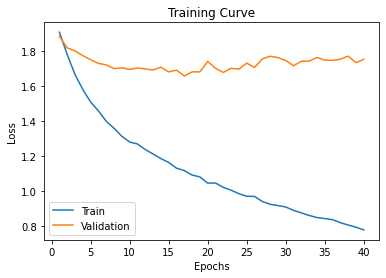

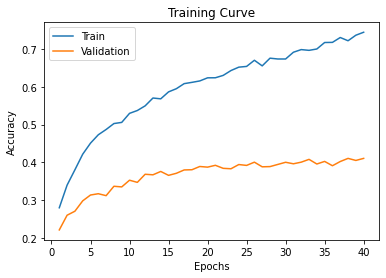

Final Training Loss: 0.7790886272083629
Final Validation Loss: 1.752036493474787
Final Training Accuracy: 0.7441071428571429
Final Validation Accuracy: 0.4105714285714286


In [0]:
model_path = get_model_name("FaceRec", batch_size=64, learning_rate=0.0002, epoch=39)
plot_training_curve(model_path)

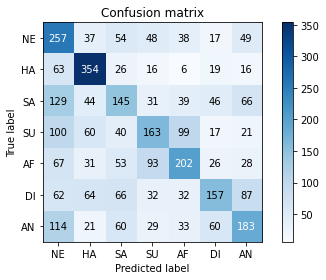

In [0]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(model, classes,
              normalize=False,
              title=None,
              cmap=plt.cm.Blues):

    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    val_feature = get_one_feature_loader(PATH_VALID_Feature,batch_size)
    y_true = []
    y_pred = []
    for features, labels in iter(val_feature):
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        features = features.cuda()
      #############################################
      
        
      out = model(features)             # forward pass
      pred = out.max(1, keepdim=True)[1]
      pred = pred.cpu()
      y_pred.append(pred.numpy()[0])
      y_true.append(labels.numpy()[0])
    # Compute confusion matrix

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

class_names = ['','NE','HA','SA','SU','AF','DI','AN']
plot_confusion_matrix(model, classes=class_names,
                      title='Confusion matrix')
plt.savefig('primary_model_confusion_matrix.png')
plt.show()